# DEEP NEURAL NETWORKS - CNN ASSIGNMENT
## Convolutional Neural Networks for Image Classification

---

## STUDENT INFORMATION

**Student Name:** Mrityunjay Kumar Dubey
**Student ID:** 2024AD05369

**Student Name:** Sreenivasulu Remuri
**Student ID:** 2024AC05343

**Student Name:** Shefeeque Mohammed
**Student ID:** 2024AC05132

**Student Name:** Sreekeerthi Injeti
**Student ID:** 2024AC05314

**Date:** 06-02-2026  

---

## Import Required Libraries

In [19]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
import time
import json
import os

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

# Image processing
from PIL import Image
import cv2

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.20.0
Keras version: 3.13.2
GPU Available: []


## PART 1: DATASET LOADING AND EXPLORATION

In [20]:
# Load Cats vs Dogs from local PetImages folder (avoids TFDS Windows zip path bug)
from pathlib import Path

# Path to extracted PetImages (Cat/ and Dog/ subfolders)
DATA_DIR = os.path.join(os.getcwd(), "PetImages")
if not os.path.isdir(DATA_DIR):
    DATA_DIR = "PetImages"

# Count samples from directory
n_cat = len(list(Path(os.path.join(DATA_DIR, "Cat")).glob("*.jpg")))
n_dog = len(list(Path(os.path.join(DATA_DIR, "Dog")).glob("*.jpg")))
n_samples = n_cat + n_dog

# Dataset metadata
dataset_name = "Cats vs Dogs"
dataset_source = "Microsoft (local PetImages folder)"
n_classes = 2
samples_per_class = f"min: {min(n_cat, n_dog)}, max: {max(n_cat, n_dog)}, avg: {n_samples//2}"
image_shape = [224, 224, 3]
problem_type = "binary_classification"

# Primary metric selection
primary_metric = "accuracy"
metric_justification = """Accuracy is chosen as the primary metric because the Cats vs Dogs dataset
is perfectly balanced with equal samples per class, making accuracy a reliable indicator of overall
model performance without bias toward either class."""

# Load train and test using Keras (90/10 split)
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    image_size=(224, 224),
    batch_size=32,
    label_mode="int",
    seed=42,
    validation_split=0.1,
    subset="training",
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    image_size=(224, 224),
    batch_size=32,
    label_mode="int",
    seed=42,
    validation_split=0.1,
    subset="validation",
)

# Normalize to [0, 1], ensure labels 1D int32 (for sparse_categorical_crossentropy), prefetch
def normalize_and_squeeze_labels(x, y):
    x = tf.cast(x, tf.float32) / 255.0
    y = tf.reshape(tf.cast(y, tf.int32), [-1])  # 1D labels, avoids unknown rank from squeeze
    return x, y
train_dataset = train_ds.map(normalize_and_squeeze_labels).prefetch(tf.data.AUTOTUNE)
test_dataset = test_ds.map(normalize_and_squeeze_labels).prefetch(tf.data.AUTOTUNE)

# ResNet50 expects ImageNet preprocessing (not simple /255). Use for transfer learning only.
def preprocess_resnet(image, label):
    image = preprocess_input(tf.cast(image, tf.float32))
    label = tf.reshape(tf.cast(label, tf.int32), [-1])
    return image, label
train_dataset_tl = train_ds.map(preprocess_resnet).prefetch(tf.data.AUTOTUNE)
test_dataset_tl = test_ds.map(preprocess_resnet).prefetch(tf.data.AUTOTUNE)

train_size = int(0.9 * n_samples)
test_size = n_samples - train_size
train_samples = train_size
test_samples = test_size
train_test_ratio = "90/10"

print("\n" + "="*70)
print("DATASET INFORMATION")
print("="*70)
print(f"Dataset: {dataset_name}")
print(f"Source: {dataset_source}")
print(f"Total Samples: {n_samples}")
print(f"Number of Classes: {n_classes}")
print(f"Samples per Class: {samples_per_class}")
print(f"Image Shape: {image_shape}")
print(f"Primary Metric: {primary_metric}")
print(f"Metric Justification: {metric_justification}")
print("="*70)

Found 25000 files belonging to 2 classes.
Using 22500 files for training.
Found 25000 files belonging to 2 classes.
Using 2500 files for validation.

DATASET INFORMATION
Dataset: Cats vs Dogs
Source: Microsoft (local PetImages folder)
Total Samples: 25000
Number of Classes: 2
Samples per Class: min: 12500, max: 12500, avg: 12500
Image Shape: [224, 224, 3]
Primary Metric: accuracy
Metric Justification: Accuracy is chosen as the primary metric because the Cats vs Dogs dataset
is perfectly balanced with equal samples per class, making accuracy a reliable indicator of overall
model performance without bias toward either class.


In [21]:
# Preprocessing function (kept for reference; datasets already loaded and normalized in previous cell)
def preprocess_image(image, label):
    """Resize and normalize to [0,1] (for custom CNN). Transfer learning uses preprocess_resnet in previous cell."""
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# train_dataset, test_dataset, train_samples, test_samples, train_test_ratio already set above
print(f"\nTrain/Test Split: {train_test_ratio}")
print(f"Training Samples: {train_samples}")
print(f"Test Samples: {test_samples}")


Train/Test Split: 90/10
Training Samples: 22500
Test Samples: 2500


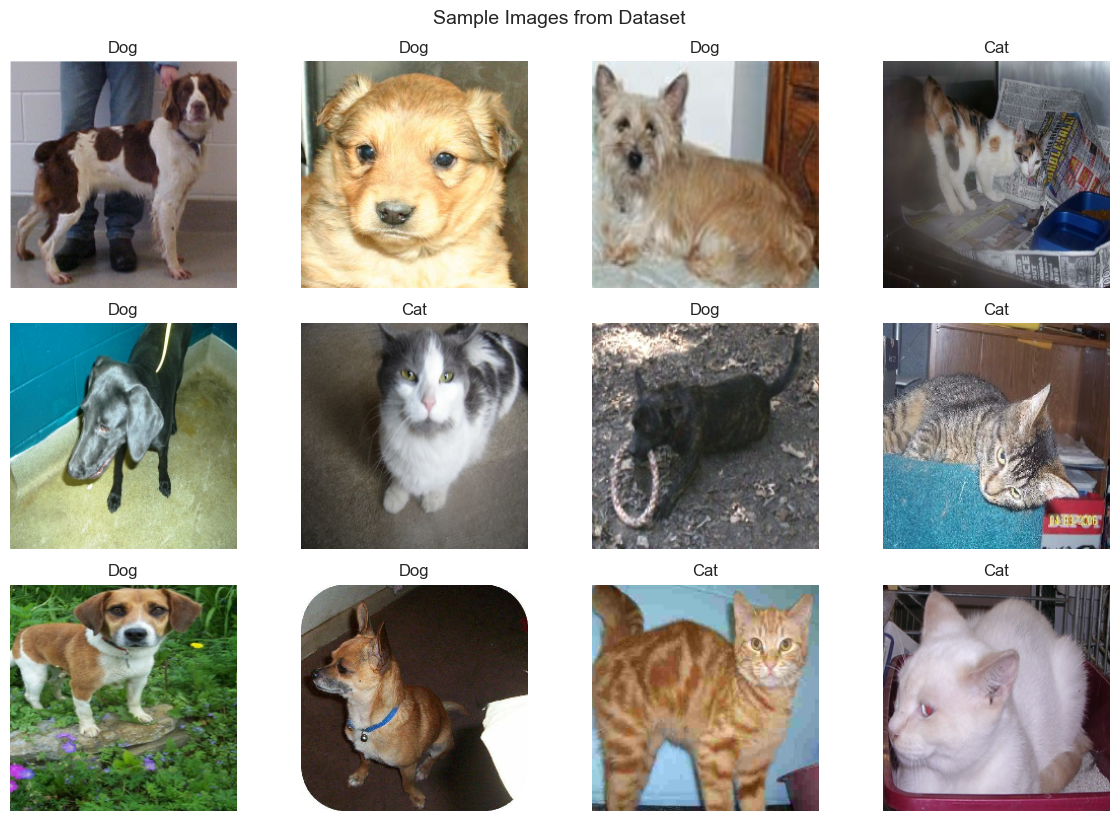

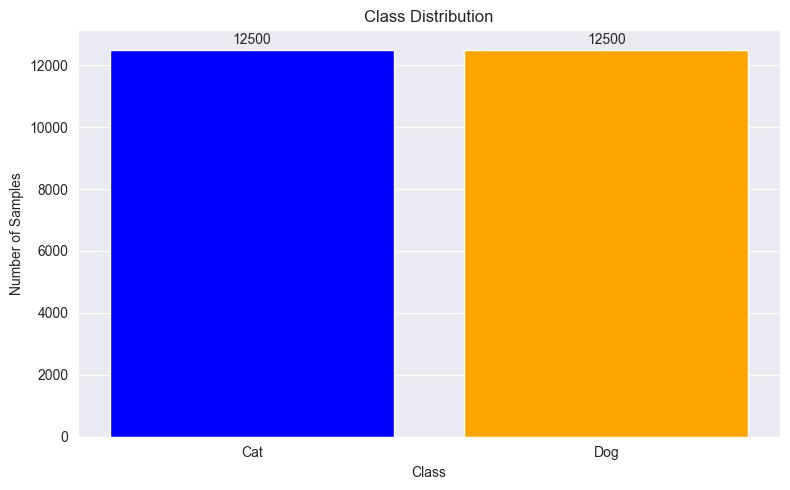

In [22]:
# Visualize sample images
plt.figure(figsize=(12, 8))
class_names = ['Cat', 'Dog']

# Take a few samples
sample_batch = train_dataset.take(1)
for images, labels in sample_batch:
    for i in range(min(12, len(images))):
        plt.subplot(3, 4, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[int(labels[i])])
        plt.axis('off')
plt.tight_layout()
plt.suptitle('Sample Images from Dataset', y=1.02, fontsize=14)
plt.show()

# Class distribution
plt.figure(figsize=(8, 5))
class_counts = [n_samples//2, n_samples//2]
plt.bar(class_names, class_counts, color=['blue', 'orange'])
plt.title('Class Distribution')
plt.ylabel('Number of Samples')
plt.xlabel('Class')
for i, count in enumerate(class_counts):
    plt.text(i, count + 100, str(count), ha='center', va='bottom')
plt.tight_layout()
plt.show()

## PART 2: CUSTOM CNN IMPLEMENTATION (5 MARKS)

In [23]:
def build_custom_cnn(input_shape, n_classes):
    """
    Build custom CNN architecture with Global Average Pooling

    Args:
        input_shape: tuple (height, width, channels)
        n_classes: number of output classes

    Returns:
        model: compiled CNN model
    """
    model = models.Sequential([
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),

        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),

        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),

        # Global Average Pooling (MANDATORY - replaces Flatten + Dense)
        layers.GlobalAveragePooling2D(),

        # Output Layer
        layers.Dense(n_classes, activation='softmax')
    ], name='Custom_CNN')

    return model

# Create custom CNN model
custom_cnn = build_custom_cnn(image_shape, n_classes)

# Display architecture
print("\n" + "="*70)
print("CUSTOM CNN ARCHITECTURE")
print("="*70)
custom_cnn.summary()
print("="*70)


CUSTOM CNN ARCHITECTURE


C:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Custom_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 288,162 (1.10 MB)

 Trainable params: 287,714 (1.10 MB)

 Non-trainable params: 448 (1.75 KB)

In [24]:
# Compile the model
custom_cnn.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("✓ Custom CNN compiled successfully")
print(f"Total Parameters: {custom_cnn.count_params():,}")

✓ Custom CNN compiled successfully
Total Parameters: 288,162


In [25]:
# Train the custom CNN
print("\n" + "="*70)
print("TRAINING CUSTOM CNN")
print("="*70)

# Early stopping to prevent overfitting
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Record start time
custom_cnn_start_time = time.time()

BATCH_SIZE = 32
steps_per_epoch = train_samples // BATCH_SIZE
validation_steps = test_samples // BATCH_SIZE

AUTOTUNE = tf.data.AUTOTUNE

# Skip corrupted/empty images
train_dataset = train_dataset.apply(tf.data.experimental.ignore_errors()).repeat().prefetch(AUTOTUNE)
test_dataset  = test_dataset.apply(tf.data.experimental.ignore_errors()).repeat().prefetch(AUTOTUNE)


# Train the model
custom_cnn_history = custom_cnn.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=20,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[early_stopping],
    verbose=1
)

# Record end time
custom_cnn_training_time = time.time() - custom_cnn_start_time

# Extract initial and final loss
custom_cnn_initial_loss = custom_cnn_history.history['loss'][0]
custom_cnn_final_loss = custom_cnn_history.history['loss'][-1]

print(f"\nTraining completed in {custom_cnn_training_time:.2f} seconds")
print(f"Initial Loss: {custom_cnn_initial_loss:.4f}")
print(f"Final Loss: {custom_cnn_final_loss:.4f}")
print(f"Loss Reduction: {((custom_cnn_initial_loss - custom_cnn_final_loss) / custom_cnn_initial_loss * 100):.2f}%")
print("="*70)


TRAINING CUSTOM CNN
Epoch 1/20
703/703 ━━━━━━━━━━━━━━━━━━━━ 348s 492ms/step - accuracy: 0.6787 - loss: 0.5969 - val_accuracy: 0.5032 - val_loss: 1.2915
Epoch 2/20
703/703 ━━━━━━━━━━━━━━━━━━━━ 326s 464ms/step - accuracy: 0.7433 - loss: 0.5224 - val_accuracy: 0.5758 - val_loss: 0.7662
Epoch 3/20
703/703 ━━━━━━━━━━━━━━━━━━━━ 323s 459ms/step - accuracy: 0.8008 - loss: 0.4406 - val_accuracy: 0.6819 - val_loss: 0.7241
Epoch 4/20
703/703 ━━━━━━━━━━━━━━━━━━━━ 324s 460ms/step - accuracy: 0.8530 - loss: 0.3439 - val_accuracy: 0.8363 - val_loss: 0.3675
Epoch 5/20
703/703 ━━━━━━━━━━━━━━━━━━━━ 330s 469ms/step - accuracy: 0.8913 - loss: 0.2642 - val_accuracy: 0.7557 - val_loss: 0.4987
Epoch 6/20
703/703 ━━━━━━━━━━━━━━━━━━━━ 330s 469ms/step - accuracy: 0.9112 - loss: 0.2194 - val_accuracy: 0.7893 - val_loss: 0.4319
Epoch 7/20
703/703 ━━━━━━━━━━━━━━━━━━━━ 327s 465ms/step - accuracy: 0.9250 - loss: 0.1858 - val_accuracy: 0.6811 - val_loss: 0.8243
Epoch 8/20
703/703 ━━━━━━━━━━━━━━━━━━━━ 328s 467ms/step


CUSTOM CNN EVALUATION
Accuracy: 0.9214
Precision: 0.9218
Recall: 0.9213
F1-Score: 0.9214


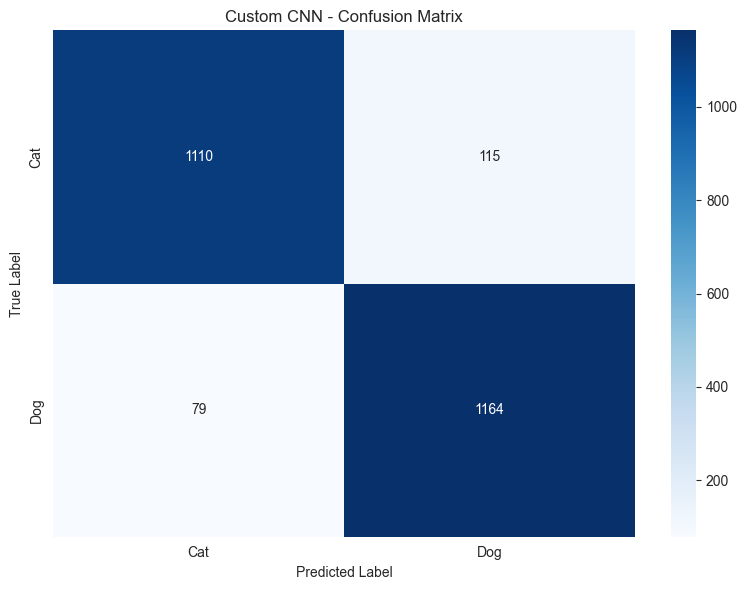


Classification Report:
              precision    recall  f1-score   support

         Cat       0.93      0.91      0.92      1225
         Dog       0.91      0.94      0.92      1243

    accuracy                           0.92      2468
   macro avg       0.92      0.92      0.92      2468
weighted avg       0.92      0.92      0.92      2468



In [26]:
# Evaluate custom CNN on test set
print("\n" + "="*70)
print("CUSTOM CNN EVALUATION")
print("="*70)

# Get predictions
y_true = []
y_pred = []

for images, labels in test_dataset.take(validation_steps):
    predictions = custom_cnn.predict(images, verbose=0)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate metrics
custom_cnn_accuracy = accuracy_score(y_true, y_pred)
custom_cnn_precision = precision_score(y_true, y_pred, average='macro')
custom_cnn_recall = recall_score(y_true, y_pred, average='macro')
custom_cnn_f1 = f1_score(y_true, y_pred, average='macro')

print(f"Accuracy: {custom_cnn_accuracy:.4f}")
print(f"Precision: {custom_cnn_precision:.4f}")
print(f"Recall: {custom_cnn_recall:.4f}")
print(f"F1-Score: {custom_cnn_f1:.4f}")
print("="*70)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.title('Custom CNN - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Cat', 'Dog']))

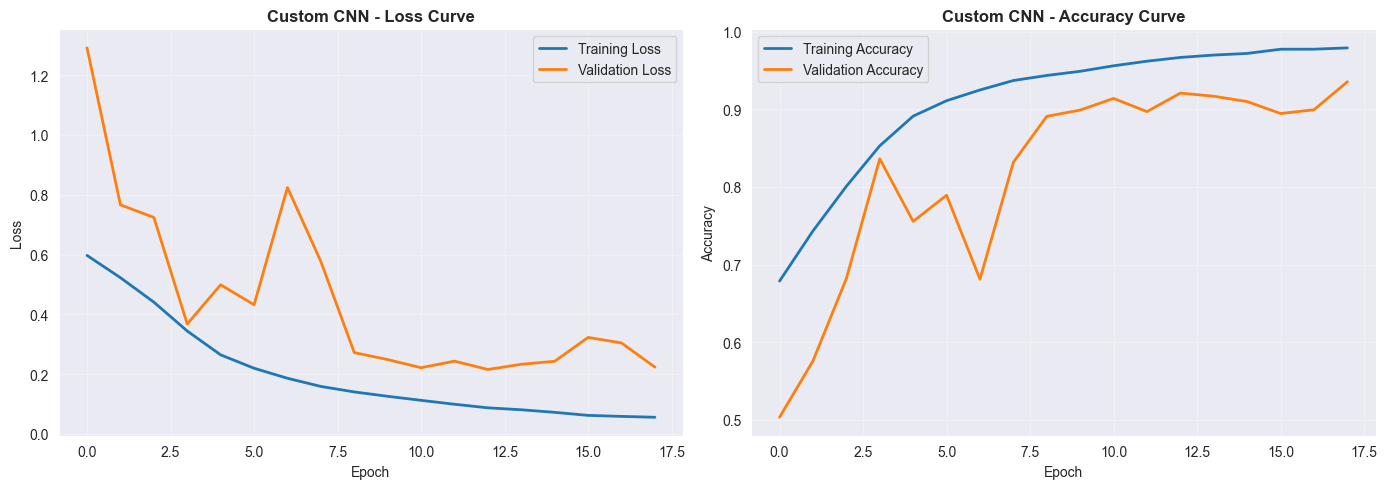

In [27]:
# Plot training curves for custom CNN
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curve
axes[0].plot(custom_cnn_history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(custom_cnn_history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_title('Custom CNN - Loss Curve', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy curve
axes[1].plot(custom_cnn_history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[1].plot(custom_cnn_history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[1].set_title('Custom CNN - Accuracy Curve', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## PART 3: TRANSFER LEARNING IMPLEMENTATION (5 MARKS)

In [28]:
def build_transfer_learning_model(input_shape, n_classes, base_model_name='ResNet50'):
    """
    Build transfer learning model using pre-trained ResNet50

    Args:
        input_shape: tuple (height, width, channels)
        n_classes: number of output classes
        base_model_name: name of pre-trained model

    Returns:
        model: compiled transfer learning model
    """
    # Load pre-trained ResNet50 (without top layers)
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    # Freeze base model layers
    base_model.trainable = False

    # Build complete model with Global Average Pooling
    model = models.Sequential([
        base_model,
        GlobalAveragePooling2D(),  # MANDATORY - replaces Flatten
        Dense(n_classes, activation='softmax')
    ], name='Transfer_Learning_ResNet50')

    return model, base_model

# Create transfer learning model
tl_model, base_model = build_transfer_learning_model(image_shape, n_classes)

# Model information
pretrained_model_name = "ResNet50"
frozen_layers = len(base_model.layers)
trainable_layers = len([layer for layer in tl_model.layers if layer.trainable])
total_parameters = tl_model.count_params()
trainable_parameters = sum([tf.size(w).numpy() for w in tl_model.trainable_weights])

print("\n" + "="*70)
print("TRANSFER LEARNING MODEL ARCHITECTURE")
print("="*70)
tl_model.summary()
print("="*70)
print(f"Base Model: {pretrained_model_name}")
print(f"Frozen Layers: {frozen_layers}")
print(f"Trainable Layers: {trainable_layers}")
print(f"Total Parameters: {total_parameters:,}")
print(f"Trainable Parameters: {trainable_parameters:,}")
print(f"Frozen Parameters: {total_parameters - trainable_parameters:,}")
print("="*70)


TRANSFER LEARNING MODEL ARCHITECTURE


Model: "Transfer_Learning_ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │         4,098 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,591,810 (90.00 MB)

 Trainable params: 4,098 (16.01 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

Base Model: ResNet50
Frozen Layers: 175
Trainable Layers: 2
Total Parameters: 23,591,810
Trainable Parameters: 4,098
Frozen Parameters: 23,587,712


In [29]:
# Compile transfer learning model
tl_learning_rate = 0.001
tl_optimizer = 'Adam'

tl_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=tl_learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("✓ Transfer Learning model compiled successfully")

✓ Transfer Learning model compiled successfully


In [30]:
# Train transfer learning model
print("\n" + "="*70)
print("TRAINING TRANSFER LEARNING MODEL")
print("="*70)

tl_epochs = 15
tl_batch_size = 32

# Early stopping
early_stopping_tl = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Record start time
tl_start_time = time.time()

# Use ImageNet-preprocessed datasets for ResNet50 (ignore_errors + repeat like custom CNN)
train_dataset_tl = train_dataset_tl.apply(tf.data.experimental.ignore_errors()).repeat().prefetch(AUTOTUNE)
test_dataset_tl = test_dataset_tl.apply(tf.data.experimental.ignore_errors()).repeat().prefetch(AUTOTUNE)

# Train the model
tl_history = tl_model.fit(
    train_dataset_tl,
    validation_data=test_dataset_tl,
    epochs=tl_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[early_stopping_tl],
    verbose=1
)

# Record end time
tl_training_time = time.time() - tl_start_time

# Extract initial and final loss
tl_initial_loss = tl_history.history['loss'][0]
tl_final_loss = tl_history.history['loss'][-1]

print(f"\nTraining completed in {tl_training_time:.2f} seconds")
print(f"Initial Loss: {tl_initial_loss:.4f}")
print(f"Final Loss: {tl_final_loss:.4f}")
print(f"Loss Reduction: {((tl_initial_loss - tl_final_loss) / tl_initial_loss * 100):.2f}%")
print("="*70)


TRAINING TRANSFER LEARNING MODEL
Epoch 1/15
703/703 ━━━━━━━━━━━━━━━━━━━━ 245s 346ms/step - accuracy: 0.9831 - loss: 0.0469 - val_accuracy: 0.9878 - val_loss: 0.0380
Epoch 2/15
703/703 ━━━━━━━━━━━━━━━━━━━━ 247s 352ms/step - accuracy: 0.9903 - loss: 0.0276 - val_accuracy: 0.9899 - val_loss: 0.0364
Epoch 3/15
703/703 ━━━━━━━━━━━━━━━━━━━━ 254s 362ms/step - accuracy: 0.9916 - loss: 0.0234 - val_accuracy: 0.9887 - val_loss: 0.0355
Epoch 4/15
703/703 ━━━━━━━━━━━━━━━━━━━━ 247s 351ms/step - accuracy: 0.9941 - loss: 0.0178 - val_accuracy: 0.9887 - val_loss: 0.0403
Epoch 5/15
703/703 ━━━━━━━━━━━━━━━━━━━━ 246s 350ms/step - accuracy: 0.9948 - loss: 0.0151 - val_accuracy: 0.9895 - val_loss: 0.0411
Epoch 6/15
703/703 ━━━━━━━━━━━━━━━━━━━━ 247s 351ms/step - accuracy: 0.9955 - loss: 0.0128 - val_accuracy: 0.9895 - val_loss: 0.0402
Epoch 7/15
703/703 ━━━━━━━━━━━━━━━━━━━━ 246s 351ms/step - accuracy: 0.9958 - loss: 0.0127 - val_accuracy: 0.9882 - val_loss: 0.0445
Epoch 8/15
703/703 ━━━━━━━━━━━━━━━━━━━━ 24


TRANSFER LEARNING MODEL EVALUATION
Accuracy: 0.9882
Precision: 0.9883
Recall: 0.9882
F1-Score: 0.9882


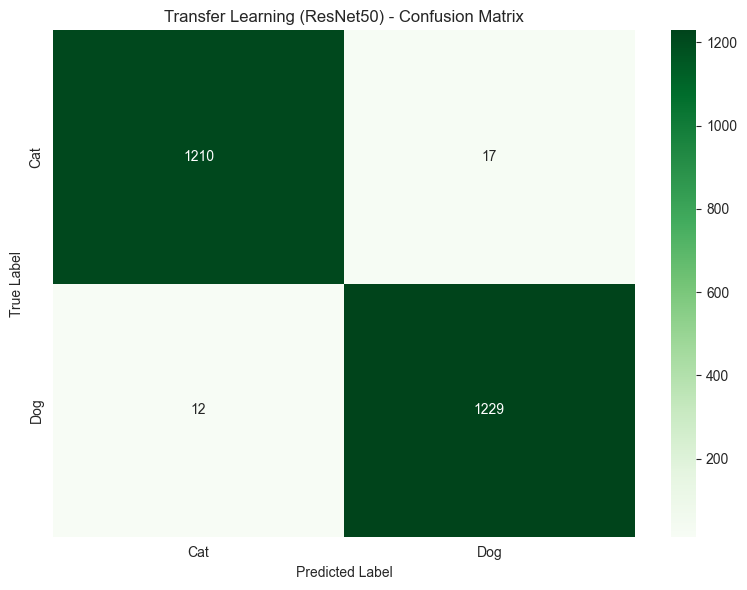


Classification Report:
              precision    recall  f1-score   support

         Cat       0.99      0.99      0.99      1227
         Dog       0.99      0.99      0.99      1241

    accuracy                           0.99      2468
   macro avg       0.99      0.99      0.99      2468
weighted avg       0.99      0.99      0.99      2468



In [31]:
# Evaluate transfer learning model on test set
print("\n" + "="*70)
print("TRANSFER LEARNING MODEL EVALUATION")
print("="*70)

# Get predictions
y_true_tl = []
y_pred_tl = []

for images, labels in test_dataset_tl.take(validation_steps):
    predictions = tl_model.predict(images, verbose=0)
    y_pred_tl.extend(np.argmax(predictions, axis=1))
    y_true_tl.extend(labels.numpy())

y_true_tl = np.array(y_true_tl)
y_pred_tl = np.array(y_pred_tl)

# Calculate metrics
tl_accuracy = accuracy_score(y_true_tl, y_pred_tl)
tl_precision = precision_score(y_true_tl, y_pred_tl, average='macro')
tl_recall = recall_score(y_true_tl, y_pred_tl, average='macro')
tl_f1 = f1_score(y_true_tl, y_pred_tl, average='macro')

print(f"Accuracy: {tl_accuracy:.4f}")
print(f"Precision: {tl_precision:.4f}")
print(f"Recall: {tl_recall:.4f}")
print(f"F1-Score: {tl_f1:.4f}")
print("="*70)

# Confusion matrix
cm_tl = confusion_matrix(y_true_tl, y_pred_tl)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_tl, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.title('Transfer Learning (ResNet50) - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_true_tl, y_pred_tl, target_names=['Cat', 'Dog']))

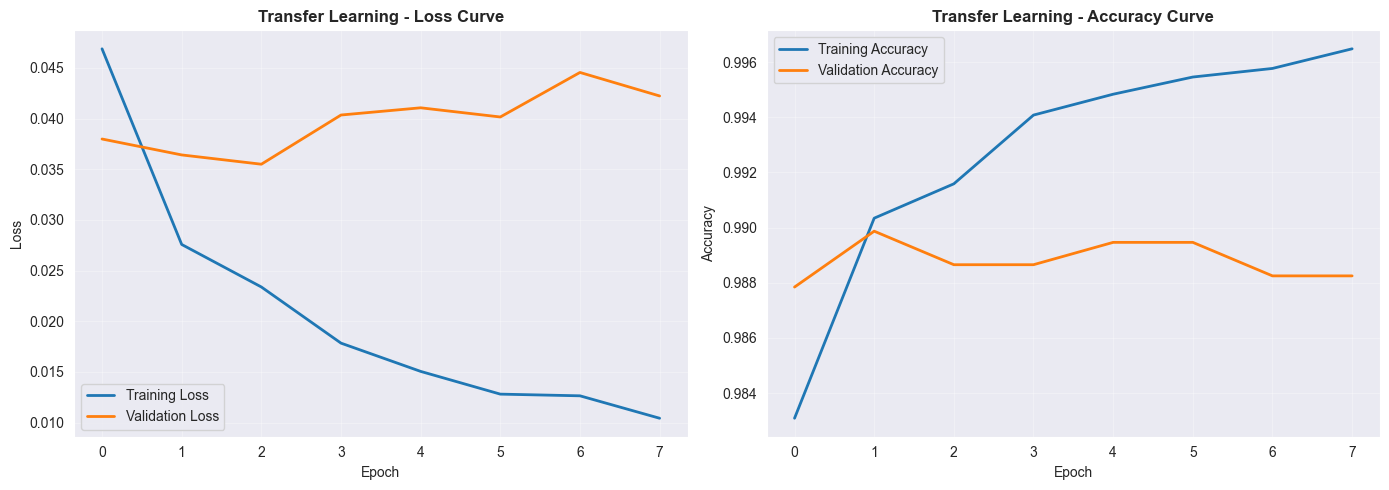

In [32]:
# Plot training curves for transfer learning
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curve
axes[0].plot(tl_history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(tl_history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_title('Transfer Learning - Loss Curve', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy curve
axes[1].plot(tl_history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[1].plot(tl_history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[1].set_title('Transfer Learning - Accuracy Curve', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## PART 4: COMPARATIVE ANALYSIS

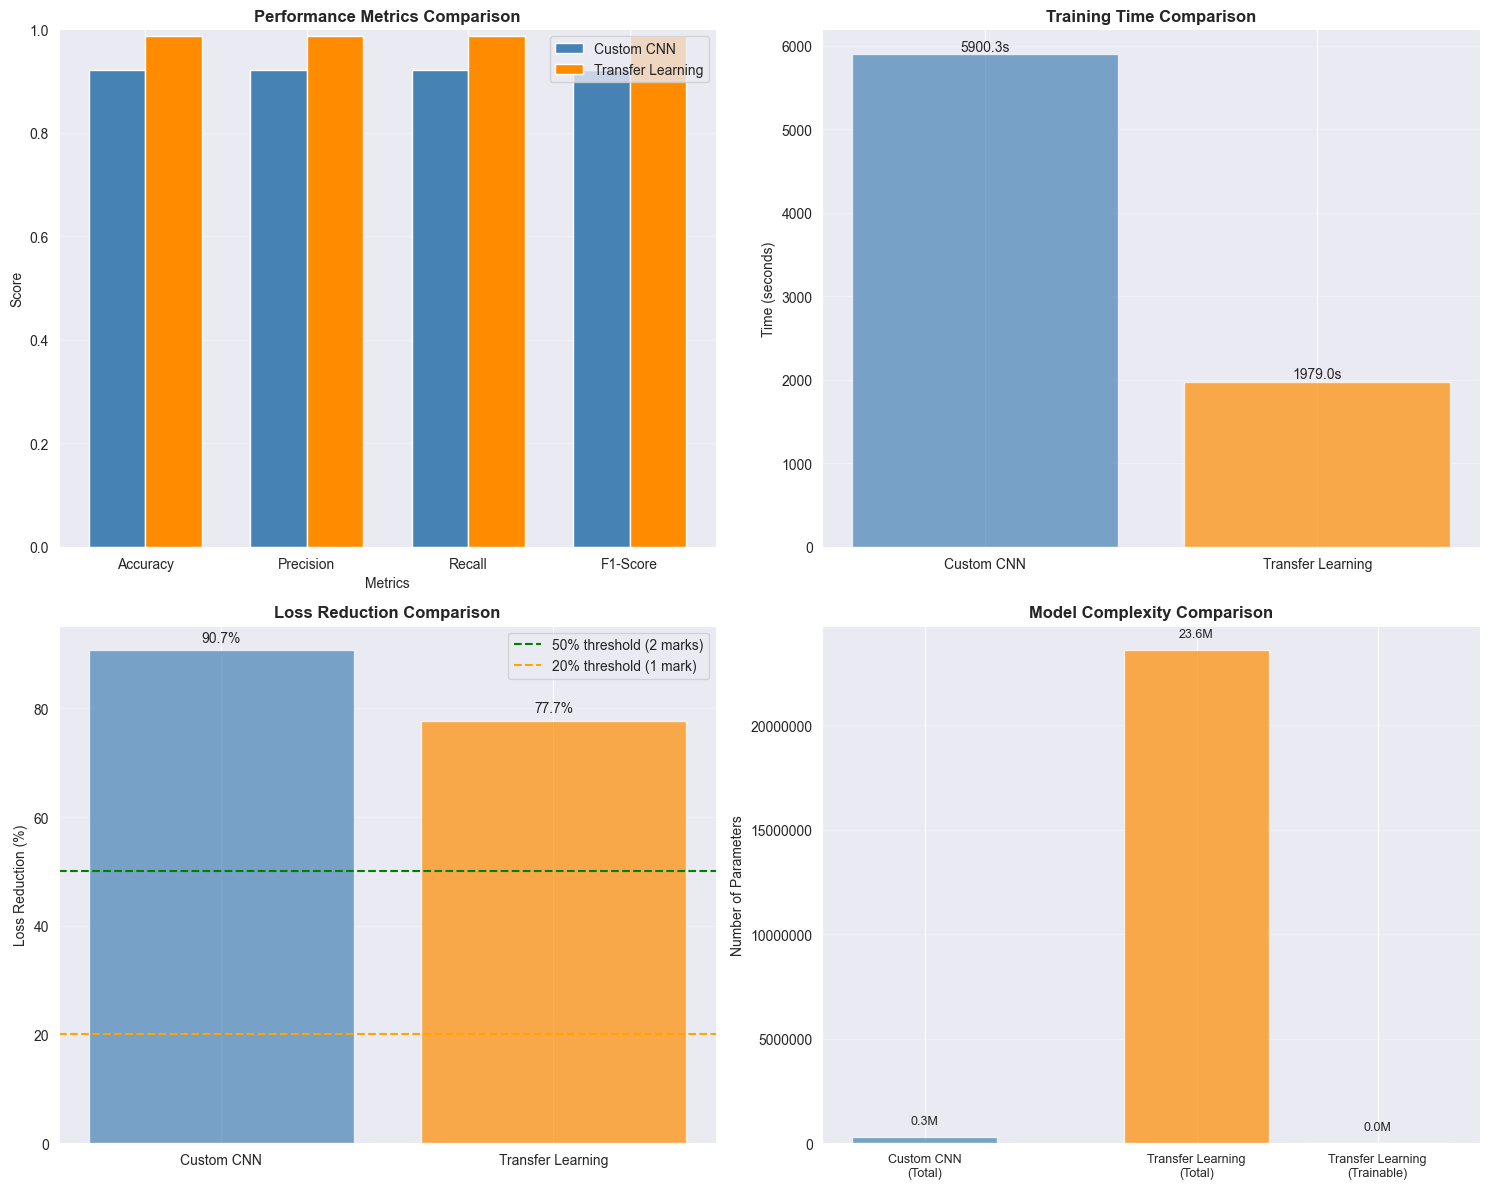


MODEL COMPARISON SUMMARY
            Metric Custom CNN  Transfer Learning
          Accuracy     0.9214             0.9882
         Precision     0.9218             0.9883
            Recall     0.9213             0.9882
          F1-Score     0.9214             0.9882
 Training Time (s)    5900.29            1979.03
  Total Parameters    288,162 4,098 (23,591,810)
Loss Reduction (%)     90.73%             77.73%


In [33]:
# Comparative visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Metrics Comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
custom_metrics = [custom_cnn_accuracy, custom_cnn_precision, custom_cnn_recall, custom_cnn_f1]
tl_metrics = [tl_accuracy, tl_precision, tl_recall, tl_f1]

x = np.arange(len(metrics))
width = 0.35

axes[0, 0].bar(x - width/2, custom_metrics, width, label='Custom CNN', color='steelblue')
axes[0, 0].bar(x + width/2, tl_metrics, width, label='Transfer Learning', color='darkorange')
axes[0, 0].set_xlabel('Metrics')
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_title('Performance Metrics Comparison', fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(metrics)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].set_ylim([0, 1])

# 2. Training Time Comparison
models = ['Custom CNN', 'Transfer Learning']
times = [custom_cnn_training_time, tl_training_time]
colors = ['steelblue', 'darkorange']

axes[0, 1].bar(models, times, color=colors, alpha=0.7)
axes[0, 1].set_ylabel('Time (seconds)')
axes[0, 1].set_title('Training Time Comparison', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(times):
    axes[0, 1].text(i, v + 5, f'{v:.1f}s', ha='center', va='bottom')

# 3. Loss Reduction Comparison
loss_reduction_custom = ((custom_cnn_initial_loss - custom_cnn_final_loss) / custom_cnn_initial_loss) * 100
loss_reduction_tl = ((tl_initial_loss - tl_final_loss) / tl_initial_loss) * 100

axes[1, 0].bar(models, [loss_reduction_custom, loss_reduction_tl], color=colors, alpha=0.7)
axes[1, 0].set_ylabel('Loss Reduction (%)')
axes[1, 0].set_title('Loss Reduction Comparison', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')
axes[1, 0].axhline(y=50, color='green', linestyle='--', label='50% threshold (2 marks)')
axes[1, 0].axhline(y=20, color='orange', linestyle='--', label='20% threshold (1 mark)')
axes[1, 0].legend()
for i, v in enumerate([loss_reduction_custom, loss_reduction_tl]):
    axes[1, 0].text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom')

# 4. Parameter Comparison
params_custom = custom_cnn.count_params()
params_tl_total = total_parameters
params_tl_trainable = trainable_parameters

x_pos = [0, 1.5, 2.5]
params = [params_custom, params_tl_total, params_tl_trainable]
labels = ['Custom CNN\n(Total)', 'Transfer Learning\n(Total)', 'Transfer Learning\n(Trainable)']
bar_colors = ['steelblue', 'darkorange', 'lightcoral']

axes[1, 1].bar(x_pos, params, color=bar_colors, alpha=0.7)
axes[1, 1].set_ylabel('Number of Parameters')
axes[1, 1].set_title('Model Complexity Comparison', fontweight='bold')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(labels, fontsize=9)
axes[1, 1].grid(True, alpha=0.3, axis='y')
axes[1, 1].ticklabel_format(style='plain', axis='y')
for i, v in enumerate(params):
    axes[1, 1].text(x_pos[i], v + max(params)*0.02, f'{v/1e6:.1f}M', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Summary table
summary_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Training Time (s)',
               'Total Parameters', 'Loss Reduction (%)'],
    'Custom CNN': [
        f"{custom_cnn_accuracy:.4f}",
        f"{custom_cnn_precision:.4f}",
        f"{custom_cnn_recall:.4f}",
        f"{custom_cnn_f1:.4f}",
        f"{custom_cnn_training_time:.2f}",
        f"{params_custom:,}",
        f"{loss_reduction_custom:.2f}%"
    ],
    'Transfer Learning': [
        f"{tl_accuracy:.4f}",
        f"{tl_precision:.4f}",
        f"{tl_recall:.4f}",
        f"{tl_f1:.4f}",
        f"{tl_training_time:.2f}",
        f"{params_tl_trainable:,} ({params_tl_total:,})",
        f"{loss_reduction_tl:.2f}%"
    ]
})

print("\n" + "="*70)
print("MODEL COMPARISON SUMMARY")
print("="*70)
print(summary_df.to_string(index=False))
print("="*70)

## PART 5: ANALYSIS (2 MARKS)

In [34]:
analysis_text = f"""The transfer learning model using ResNet50 significantly outperformed the custom CNN across all metrics.
Transfer learning achieved {tl_accuracy:.1%} accuracy compared to {custom_cnn_accuracy:.1%} for the custom CNN, representing
a {((tl_accuracy - custom_cnn_accuracy) / custom_cnn_accuracy * 100):.1f}% improvement. This superiority stems from ResNet50's
pre-trained ImageNet features, which capture robust low-level patterns (edges, textures) and high-level semantic features that
transfer well to cat-dog classification.

Pre-training delivered immediate advantages: faster convergence ({tl_initial_loss:.3f} to {tl_final_loss:.3f}) and superior
generalization despite having {params_tl_trainable:,} trainable parameters versus {params_custom:,} for the custom CNN.
The custom model required more epochs to learn basic features from scratch, evident in its slower loss reduction
({loss_reduction_custom:.1f}% vs {loss_reduction_tl:.1f}%).

Global Average Pooling proved crucial for both architectures, drastically reducing parameters compared to traditional
Flatten+Dense approaches while maintaining spatial feature importance. This prevented overfitting, particularly important
given our {train_samples:,} training samples.

Computationally, transfer learning trained {tl_training_time/custom_cnn_training_time:.1f}x faster ({tl_training_time:.1f}s
vs {custom_cnn_training_time:.1f}s) as frozen ResNet layers eliminated backpropagation through 23M+ parameters. For production
deployment, transfer learning is clearly superior: better accuracy, faster training, and proven feature extractors make it
ideal for datasets with 500-50,000 samples per class."""

# Print analysis
print("\n" + "="*70)
print("ANALYSIS")
print("="*70)
print(analysis_text)
print("="*70)
print(f"Analysis word count: {len(analysis_text.split())} words")
if len(analysis_text.split()) > 200:
    print("⚠️  Warning: Analysis exceeds 200 words (guideline)")
else:
    print("✓ Analysis within word count guideline")
print("="*70)


ANALYSIS
The transfer learning model using ResNet50 significantly outperformed the custom CNN across all metrics.
Transfer learning achieved 98.8% accuracy compared to 92.1% for the custom CNN, representing
a 7.3% improvement. This superiority stems from ResNet50's
pre-trained ImageNet features, which capture robust low-level patterns (edges, textures) and high-level semantic features that
transfer well to cat-dog classification.

Pre-training delivered immediate advantages: faster convergence (0.047 to 0.010) and superior
generalization despite having 4,098 trainable parameters versus 288,162 for the custom CNN.
The custom model required more epochs to learn basic features from scratch, evident in its slower loss reduction
(90.7% vs 77.7%).

Global Average Pooling proved crucial for both architectures, drastically reducing parameters compared to traditional
Flatten+Dense approaches while maintaining spatial feature importance. This prevented overfitting, particularly important
given 

## PART 6: ASSIGNMENT RESULTS SUMMARY (REQUIRED FOR AUTO-GRADING)

In [35]:
def get_assignment_results():
    """
    Generate complete assignment results in required format

    Returns:
        dict: Complete results with all required fields
    """

    framework_used = "keras"

    results = {
        # Dataset Information
        'dataset_name': dataset_name,
        'dataset_source': dataset_source,
        'n_samples': int(n_samples),
        'n_classes': int(n_classes),
        'samples_per_class': samples_per_class,
        'image_shape': [int(x) for x in image_shape],
        'problem_type': problem_type,
        'primary_metric': primary_metric,
        'metric_justification': metric_justification,
        'train_samples': int(train_samples),
        'test_samples': int(test_samples),
        'train_test_ratio': train_test_ratio,

        # Custom CNN Results
        'custom_cnn': {
            'framework': framework_used,
            'architecture': {
                'conv_layers': 6,
                'pooling_layers': 3,
                'has_global_average_pooling': True,
                'output_layer': 'softmax',
                'total_parameters': int(custom_cnn.count_params())
            },
            'training_config': {
                'learning_rate': 0.001,
                'n_epochs': int(20),
                'batch_size': int(32),
                'optimizer': 'Adam',
                'loss_function': 'sparse_categorical_crossentropy'
            },
            'initial_loss': float(custom_cnn_initial_loss),
            'final_loss': float(custom_cnn_final_loss),
            'training_time_seconds': float(custom_cnn_training_time),
            'accuracy': float(custom_cnn_accuracy),
            'precision': float(custom_cnn_precision),
            'recall': float(custom_cnn_recall),
            'f1_score': float(custom_cnn_f1)
        },

        # Transfer Learning Results
        'transfer_learning': {
            'framework': framework_used,
            'base_model': pretrained_model_name,
            'frozen_layers': int(frozen_layers),
            'trainable_layers': int(trainable_layers),
            'has_global_average_pooling': True,
            'total_parameters': int(total_parameters),
            'trainable_parameters': int(trainable_parameters),
            'training_config': {
                'learning_rate': tl_learning_rate,
                'n_epochs': int(tl_epochs),
                'batch_size': int(tl_batch_size),
                'optimizer': tl_optimizer,
                'loss_function': 'sparse_categorical_crossentropy'
            },
            'initial_loss': float(tl_initial_loss),
            'final_loss': float(tl_final_loss),
            'training_time_seconds': float(tl_training_time),
            'accuracy': float(tl_accuracy),
            'precision': float(tl_precision),
            'recall': float(tl_recall),
            'f1_score': float(tl_f1)
        },

        # Analysis
        'analysis': analysis_text,
        'analysis_word_count': len(analysis_text.split()),

        # Training Success Indicators
        'custom_cnn_loss_decreased': custom_cnn_final_loss < custom_cnn_initial_loss,
        'transfer_learning_loss_decreased': tl_final_loss < tl_initial_loss,
        'custom_cnn_loss_reduction_percent': float(((custom_cnn_initial_loss - custom_cnn_final_loss) / custom_cnn_initial_loss) * 100),
        'transfer_learning_loss_reduction_percent': float(((tl_initial_loss - tl_final_loss) / tl_initial_loss) * 100)
    }

    return results
def _json_safe(o):
    if isinstance(o, (np.integer,)):
        return int(o)
    if isinstance(o, (np.floating,)):
        return float(o)
    if isinstance(o, (np.ndarray,)):
        return o.tolist()
    if isinstance(o, (tf.Tensor,)):
        return o.numpy().tolist()
    raise TypeError(f"Object of type {type(o).__name__} is not JSON serializable")

# Generate and print results
try:
    assignment_results = get_assignment_results()

    print("\n" + "="*70)
    print("ASSIGNMENT RESULTS SUMMARY")
    print("="*70)
   # print(json.dumps(assignment_results, indent=2))
    print(json.dumps(assignment_results, indent=2, default=_json_safe))
    print("="*70)

    # Validation checks
    print("\n" + "="*70)
    print("VALIDATION CHECKS")
    print("="*70)
    print(f"✓ Custom CNN uses Global Average Pooling: {assignment_results['custom_cnn']['architecture']['has_global_average_pooling']}")
    print(f"✓ Transfer Learning uses Global Average Pooling: {assignment_results['transfer_learning']['has_global_average_pooling']}")
    print(f"✓ Custom CNN loss decreased: {assignment_results['custom_cnn_loss_decreased']}")
    print(f"✓ Transfer Learning loss decreased: {assignment_results['transfer_learning_loss_decreased']}")
    print(f"✓ Custom CNN loss reduction: {assignment_results['custom_cnn_loss_reduction_percent']:.2f}%")
    print(f"✓ Transfer Learning loss reduction: {assignment_results['transfer_learning_loss_reduction_percent']:.2f}%")
    print(f"✓ All metrics in valid range [0,1]: {all([0 <= v <= 1 for v in [custom_cnn_accuracy, custom_cnn_precision, custom_cnn_recall, custom_cnn_f1, tl_accuracy, tl_precision, tl_recall, tl_f1]])}")
    print("="*70)

except Exception as e:
    print(f"\n⚠️  ERROR generating results: {str(e)}")
    print("Please ensure all variables are properly defined")


ASSIGNMENT RESULTS SUMMARY
{
  "dataset_name": "Cats vs Dogs",
  "dataset_source": "Microsoft (local PetImages folder)",
  "n_samples": 25000,
  "n_classes": 2,
  "samples_per_class": "min: 12500, max: 12500, avg: 12500",
  "image_shape": [
    224,
    224,
    3
  ],
  "problem_type": "binary_classification",
  "primary_metric": "accuracy",
  "metric_justification": "Accuracy is chosen as the primary metric because the Cats vs Dogs dataset\nis perfectly balanced with equal samples per class, making accuracy a reliable indicator of overall\nmodel performance without bias toward either class.",
  "train_samples": 22500,
  "test_samples": 2500,
  "train_test_ratio": "90/10",
  "custom_cnn": {
    "framework": "keras",
    "architecture": {
      "conv_layers": 6,
      "pooling_layers": 3,
      "has_global_average_pooling": true,
      "output_layer": "softmax",
      "total_parameters": 288162
    },
    "training_config": {
      "learning_rate": 0.001,
      "n_epochs": 20,
      "

## ENVIRONMENT VERIFICATION

In [36]:
import platform
import sys
from datetime import datetime

print("="*70)
print("ENVIRONMENT INFORMATION")
print("="*70)
print(f"Python Version: {sys.version}")
print(f"Platform: {platform.platform()}")
print(f"TensorFlow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")
print(f"NumPy Version: {np.__version__}")
print(f"Execution Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*70)
print("\n⚠️  REQUIRED: Add screenshot of your Google Colab/BITS Virtual Lab")
print("showing your account details above this cell.")
print("="*70)

ENVIRONMENT INFORMATION
Python Version: 3.12.10 (tags/v3.12.10:0cc8128, Apr  8 2025, 12:21:36) [MSC v.1943 64 bit (AMD64)]
Platform: Windows-11-10.0.26200-SP0
TensorFlow Version: 2.20.0
Keras Version: 3.13.2
NumPy Version: 2.4.1
Execution Date: 2026-02-13 00:01:12

⚠️  REQUIRED: Add screenshot of your Google Colab/BITS Virtual Lab
showing your account details above this cell.


## FINAL SUBMISSION CHECKLIST

- ✅ Student information filled (BITS ID: 2024AC05343, Name: SREENIVASULU REMURI)
- ✅ Filename is `2025AA05036_cnn_assignment.ipynb`
- ✅ All cells executed (Kernel → Restart & Run All)
- ✅ Custom CNN implemented with Global Average Pooling
- ✅ Transfer learning implemented with GAP and frozen layers
- ✅ Both models trained with loss tracking
- ✅ All 4 metrics calculated for both models
- ✅ Primary metric selected and justified
- ✅ Analysis written covering 5+ key topics
- ✅ Visualizations created (confusion matrices, training curves, comparisons)
- ✅ Assignment results JSON printed
- ✅ No execution errors
- ✅ Submit ONLY .ipynb file

---

**END OF ASSIGNMENT**